In [68]:
#Initial setup
import warnings
import immutabledict
warnings.simplefilter(action='ignore', category=FutureWarning)
import glob
import dask.dataframe as dd
import os
import pandas as pd
import sys
import io
import matplotlib.pyplot as plt
import numpy as np
import torch


# Add the source files from the waymo open dataset.
sys.path.insert(0, '/home/patel.aryam/waymo_dl/waymo-open-dataset/src')


from waymo_open_dataset import v2
import waymo_open_dataset.dataset_pb2 as open_dataset
from typing import Optional, TypeVar, Union, Any, List, Sequence, Tuple, Optional, Iterator, Dict 
from PIL import Image
from torchvision import transforms
from waymo_open_dataset.utils import camera_segmentation_utils

# Path to the directory with all components
dataset_dir = '/scratch/patel.aryam/training'
path_to_context = '/home/patel.aryam/waymo_dl/2d_pvps_training_frames.txt'


## Merging the Data

In [69]:
#Data tags -
data_to_read = ['camera_image', 'camera_segmentation'] 

In [70]:
def get_context_data(filepath):
    """Gets the context data from the file path"""
    df = dd.read_csv(filepath, header=None, names=['context_name', 'timestamps'], sep=',')
    return df

In [71]:
def read(tag: str, context_name: str) -> dd.DataFrame:
    """Creates a Dask DataFrame for the component specified by its tag and context name."""
    print(context_name)
    paths = glob.glob(os.path.join(dataset_dir, tag, f"{context_name}.parquet"))
    print(paths)
    return dd.read_parquet(paths)

In [72]:
# Merge Functions:
_AnyDataFrame = Union[pd.DataFrame, dd.DataFrame]
_DataFrame = TypeVar('_DataFrame')


def _select_key_columns(df: _AnyDataFrame, prefix: str) -> set[str]:
  return set([c for c in df.columns if c.startswith(prefix)])


def _how(left_nullable: bool = False, right_nullable: bool = False):
  if left_nullable and right_nullable:
    return 'outer'
  elif left_nullable and not right_nullable:
    return 'right'
  elif not left_nullable and right_nullable:
    return 'left'
  else:
    return 'inner'


def _cast_keys(src, dst, keys):
  for key in keys:
    if dst.dtypes[key] != src.dtypes[key]:
      dst[key] = dst[key].astype(src[key].dtype)


def _group_by(src, keys):
  dst = src.groupby(list(keys)).agg(list).reset_index()
  # Fix key types automatically created from the MultiIndex
  _cast_keys(src, dst, keys)
  return dst


def merge(
    left: _DataFrame,
    right: _DataFrame,
    left_nullable: bool = False,
    right_nullable: bool = False,
    left_group: bool = False,
    right_group: bool = False,
    key_prefix: str = 'key.',
) -> _DataFrame:
  """
  Merges two tables using automatically select columns.

  This operation is called JOIN in SQL, but we use "merge" to make it consistent
  with Pandas and Dask.

  If the sets of key columns in the left and right tables do not match it will
  group by shared columns first to avoid unexpected cross products of unmatched
  columns.

  When both `left_nullable` and `right_nullable` are set to True it will perform
  an outer JOIN and output all rows from both tables in the output. When both
  set to False it will perform INNER join, otherwise - LEFT or RIGHT joins
  accordingly.

  Args:
    left: a left table.
    right: a right table.
    left_nullable: if True output may contain rows where only right columns are
      present, while left columns are null.
    right_nullable: if True output may contain rows where only left columns are
      present, while right columns are null.
    left_group: If True it will group records in the left table by common keys.
    right_group: If True it will group records in the right table by common
      keys.
    key_prefix: a string prefix used to select key columns.

  Returns:
    A new table which is the result of the join operation.
  """
  left_keys = _select_key_columns(left, key_prefix)
  right_keys = _select_key_columns(right, key_prefix)
  common_keys = left_keys.intersection(right_keys)
  if left_group and left_keys != common_keys:
    left = _group_by(left, common_keys)
  if right_group and right_keys != common_keys:
    right = _group_by(right, common_keys)
  return left.merge(
      right, on=list(common_keys), how=_how(left_nullable, right_nullable)
  )


In [73]:
"""
This function takes in three arguments:

-key_names: a sequence of column names for the keys used to group the DataFrame.
-key_values: a sequence of values for the keys used to group the DataFrame.
-row: a Dask DataFrame that contains the grouped data.

The function then iterates over each row in the DataFrame, and for each row, it creates
a dictionary that contains the values of the row as well as the key names and values. 
The resulting dictionary is then yielded to the calling function as an iterator.

The ungroup_row function is used to split a group of DataFrames into individual dictionaries,
where each dictionary represents a single row of data. This function is typically used 
after a groupby operation in Dask to transform the grouped DataFrame into a format that can
be processed more easily.
"""
def ungroup_row(key_names: Sequence[str],
                key_values: Sequence[str],
                row: dd.DataFrame) -> Iterator[Dict[str, Any]]:
  """Splits a group of dataframes into individual dicts."""
  keys = dict(zip(key_names, key_values))
  cols, cells = list(zip(*[(col, cell) for col, cell in r.items()]))
  for values in zip(*cells):
    yield dict(zip(cols, values), **keys)

In [74]:
def _pad_to_common_shape(label):
  return np.pad(label, [[1280 - label.shape[0], 0], [0, 0], [0, 0]])

In [75]:
# Sanity check.
keys = ['context_name']
df_context = get_context_data(path_to_context)
df_context = df_context.groupby(keys, group_keys=False).agg(list).reset_index()
context_names = df_context['context_name'].compute().tolist()
print("Number of context lists - ", len(context_names))
df_context.head()

Number of context lists -  696


,context_name,timestamps
0,10017090168044687777_6380_000_6400_000,"[1550083469645130, 1550083470045260, 155008347..."
1,10023947602400723454_1120_000_1140_000,"[1552440197761529, 1552440198161543, 155244019..."
2,1005081002024129653_5313_150_5333_150,"[1510593602540538, 1510593602940141, 151059360..."
3,10061305430875486848_1080_000_1100_000,"[1552933154425267, 1552933154823844, 155293315..."
4,10072140764565668044_4060_000_4080_000,"[1552696052686347, 1552696053087827, 155269605..."


In [76]:
camera_images = read(data_to_read[0], context_names[1])
columns_to_drop = ['[CameraImageComponent].pose.transform',
                   '[CameraImageComponent].velocity.linear_velocity.x',
                   '[CameraImageComponent].velocity.linear_velocity.y',
                   '[CameraImageComponent].velocity.linear_velocity.z',
                   '[CameraImageComponent].velocity.angular_velocity.x',
                   '[CameraImageComponent].velocity.angular_velocity.y',
                   '[CameraImageComponent].velocity.angular_velocity.z',
                   '[CameraImageComponent].pose_timestamp',
                   '[CameraImageComponent].rolling_shutter_params.shutter',
                   '[CameraImageComponent].rolling_shutter_params.camera_trigger_time',
                   '[CameraImageComponent].rolling_shutter_params.camera_readout_done_time']
camera_images = camera_images.drop(columns_to_drop, axis = 1).reset_index()
camera_images.head()

10023947602400723454_1120_000_1140_000
['/scratch/patel.aryam/training/camera_image/10023947602400723454_1120_000_1140_000.parquet']


,index,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,[CameraImageComponent].image
0,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440195362591,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440195362591,2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440195362591,4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440195362591,3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440195362591,5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [77]:
camera_segmentation = read(data_to_read[1], context_names[1]).reset_index()
camera_segmentation.head()

10023947602400723454_1120_000_1140_000
['/scratch/patel.aryam/training/camera_segmentation/10023947602400723454_1120_000_1140_000.parquet']


,index,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,[CameraSegmentationLabelComponent].panoptic_label_divisor,[CameraSegmentationLabelComponent].panoptic_label,[CameraSegmentationLabelComponent].instance_id_to_global_id_mapping.local_instance_ids,[CameraSegmentationLabelComponent].instance_id_to_global_id_mapping.global_instance_ids,[CameraSegmentationLabelComponent].instance_id_to_global_id_mapping.is_tracked,[CameraSegmentationLabelComponent].sequence_id,[CameraSegmentationLabelComponent].num_cameras_covered
0,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440197761529,1,1000,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...","[True, True, True, True, True, True, True, Tru...",8889617406752555947,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440197761529,2,1000,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[1, 2, 3, 4, 5, 6, 7, 8]","[2, 4, 5, 6, 7, 8, 9, 69]","[True, True, True, True, True, True, True, True]",8889617406752555947,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440197761529,4,1000,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[1, 2, 3]","[1, 2, 3]","[True, True, True]",8889617406752555947,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\..."
3,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440197761529,3,1000,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[1, 2, 3, 4, 5, 6, 7, 8]","[29, 30, 35, 36, 37, 38, 39, 40]","[True, True, True, True, True, True, True, True]",8889617406752555947,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,10023947602400723454_1120_000_1140_000;1552440...,10023947602400723454_1120_000_1140_000,1552440197761529,5,1000,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[1, 2]","[35, 36]","[True, True]",8889617406752555947,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\..."


In [78]:
# Function to take in the context_name as input, use the data to read tag and give a merged and agg dataset
def context_to_dataset(context_name:str) -> dd.DataFrame:
    #Data tags -
    data_to_read = ['camera_image', 'camera_segmentation'] 
    #Frame keys- 
    frame_keys = ['key.segment_context_name', 'key.frame_timestamp_micros']
    # Columns to drop from camera
    columns_to_drop = ['[CameraImageComponent].pose.transform',
                       '[CameraImageComponent].velocity.linear_velocity.x',
                       '[CameraImageComponent].velocity.linear_velocity.y',
                       '[CameraImageComponent].velocity.linear_velocity.z',
                       '[CameraImageComponent].velocity.angular_velocity.x',
                       '[CameraImageComponent].velocity.angular_velocity.y',
                       '[CameraImageComponent].velocity.angular_velocity.z',
                       '[CameraImageComponent].pose_timestamp',
                       '[CameraImageComponent].rolling_shutter_params.shutter',
                       '[CameraImageComponent].rolling_shutter_params.camera_trigger_time',
                       '[CameraImageComponent].rolling_shutter_params.camera_readout_done_time']    
    camera_images = read(data_to_read[0], context_name)
    camera_images = camera_images.drop(columns_to_drop, axis = 1) 
    
    camera_segmentation = read(data_to_read[1], context_name)
    
    # Merge the dataset
    df = merge(camera_images, camera_segmentation, right_group = True)
    
    # Aggregate the data acording to the frame keys:
    # Group segmentation labels into frames by context name and timestamp.
    df = df.groupby(frame_keys, group_keys=False).agg(list)
    
    return df
    
    


In [104]:
# Get the Image and segmentation columns.
image_w_segmentation = context_to_dataset(context_names[0])
image_w_segmentation.head()

10017090168044687777_6380_000_6400_000
['/scratch/patel.aryam/training/camera_image/10017090168044687777_6380_000_6400_000.parquet']
10017090168044687777_6380_000_6400_000
['/scratch/patel.aryam/training/camera_segmentation/10017090168044687777_6380_000_6400_000.parquet']


key.camera_name  \
key.segment_context_name               key.frame_timestamp_micros                    
10017090168044687777_6380_000_6400_000 1550083469645130            [1, 2, 4, 3, 5]   
                                       1550083470045260            [1, 2, 4, 3, 5]   
                                       1550083470245288            [1, 2, 4, 3, 5]   
                                       1550083470445324            [1, 2, 4, 3, 5]   
                                       1550083470845389            [1, 2, 4, 3, 5]   

                                                                                        [CameraImageComponent].image  \
key.segment_context_name               key.frame_timestamp_micros                                                      
10017090168044687777_6380_000_6400_000 1550083469645130            [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   
                                       1550083470045260            [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   
                                       1550083470245288            [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   
                                       1550083470445324            [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   
                                       1550083470845389            [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   

                                                                  [CameraSegmentationLabelComponent].panoptic_label_divisor  \
key.segment_context_name               key.frame_timestamp_micros                                                             
10017090168044687777_6380_000_6400_000 1550083469645130                               [1000, 1000, 1000, 1000, 1000]          
                                       1550083470045260                               [1000, 1000, 1000, 1000, 1000]          
                                       1550083470245288                               [1000, 1000, 1000, 1000, 1000]          
                                       1550083470445324                               [1000, 1000, 1000, 1000, 1000]          
                                       1550083470845389                               [1000, 1000, 1000, 1000, 1000]          

                                                                   [CameraSegmentationLabelComponent].panoptic_label  \
key.segment_context_name               key.frame_timestamp_micros                                                      
10017090168044687777_6380_000_6400_000 1550083469645130            [b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00...   
                                       1550083470045260            [b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00...   
                                       1550083470245288            [b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00...   
                                       1550083470445324            [b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00...   
                                       1550083470845389            [b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00...   

                                                                  [CameraSegmentationLabelComponent].instance_id_to_global_id_mapping.local_instance_ids  \
key.segment_context_name               key.frame_timestamp_micros                                                                                          
10017090168044687777_6380_000_6400_000 1550083469645130            [[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4, 5, 6...                                       
                                       1550083470045260            [[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3], [1, 2]...                                       
                                       1550083470245288            [[1, 2, 3, 4, 5], [1, 2, 3], [1, 2, 3, 4, 5, 6...                                       
                                       1550083470445324            [[1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3], [1, 2, 

In [105]:
# cam_images_list = []
# for i, (key_values, r) in enumerate(image_w_segmentation.iterrows()):
#     if i >= 5:
#         break
#     print(r)

# camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT,
#                               open_dataset.CameraName.FRONT_LEFT,
#                               open_dataset.CameraName.FRONT,
#                               open_dataset.CameraName.FRONT_RIGHT,
#                               open_dataset.CameraName.SIDE_RIGHT]
# images_order = []
# for it, label_list in enumerate(cam_images_list):
#     print(label_list)

## Visualizing the data side by side.

In [106]:
cam_segmentation_list = []
for i, (key_values, r) in enumerate(image_w_segmentation.iterrows()):
  # Read three sequences of 5 camera images for this demo.
  if i >= 5:
    break
  # Store a segmentation label component for each camera.
  cam_segmentation_list.append([v2.CameraSegmentationLabelComponent.from_dict(d) for d in ungroup_row(frame_keys, key_values, r)])
    
# Order labels from left to right for visualization later.
# For each frame with segmentation labels, all cameras should have a label.
camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT,
                              open_dataset.CameraName.FRONT_LEFT,
                              open_dataset.CameraName.FRONT,
                              open_dataset.CameraName.FRONT_RIGHT,
                              open_dataset.CameraName.SIDE_RIGHT]

segmentation_protos_ordered = []
for it, label_list in enumerate(cam_segmentation_list):
    segmentation_dict = {label.key.camera_name: label for label in label_list}
    segmentation_protos_ordered.append([segmentation_dict[name] for name in camera_left_to_right_order])
# Decode a single panoptic label.
panoptic_label_front = camera_segmentation_utils.decode_single_panoptic_label_from_proto(
    segmentation_protos_ordered[0][open_dataset.CameraName.FRONT]
)
print(panoptic_label_front.dtype)
print(panoptic_label_front.shape)

semantic_label_front, instance_label_front = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(
    panoptic_label_front,
    segmentation_protos_ordered[0][open_dataset.CameraName.FRONT].panoptic_label_divisor
)

segmentation_protos_flat = sum(segmentation_protos_ordered, [])
panoptic_labels, num_cameras_covered, is_tracked_masks, panoptic_label_divisor = camera_segmentation_utils.decode_multi_frame_panoptic_labels_from_segmentation_labels(
    segmentation_protos_flat, remap_to_global=True
)

# We can further separate the semantic and instance labels from the panoptic
# labels.
NUM_CAMERA_FRAMES = 5

semantic_labels_multiframe = []
instance_labels_multiframe = []
# Takes 5 frames.
for i in range(0, len(segmentation_protos_flat), NUM_CAMERA_FRAMES):
  semantic_labels = []
  instance_labels = []
  for j in range(NUM_CAMERA_FRAMES):
    semantic_label, instance_label = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(
      panoptic_labels[i + j], panoptic_label_divisor)
    semantic_labels.append(semantic_label)
    instance_labels.append(instance_label)
  semantic_labels_multiframe.append(semantic_labels)
  instance_labels_multiframe.append(instance_labels)
# Pad labels to a common size so that they can be concatenated.
instance_labels = [[_pad_to_common_shape(label) for label in instance_labels] for instance_labels in instance_labels_multiframe]
semantic_labels = [[_pad_to_common_shape(label) for label in semantic_labels] for semantic_labels in semantic_labels_multiframe]
instance_labels = [np.concatenate(label, axis=1) for label in instance_labels]
semantic_labels = [np.concatenate(label, axis=1) for label in semantic_labels]

instance_label_concat = np.concatenate(instance_labels, axis=0)
semantic_label_concat = np.concatenate(semantic_labels, axis=0)
panoptic_label_rgb = camera_segmentation_utils.panoptic_label_to_rgb(semantic_label_concat, instance_label_concat)

print(panoptic_label_rgb.shape)

uint16
(1280, 1920, 1)
(6400, 9600, 3)


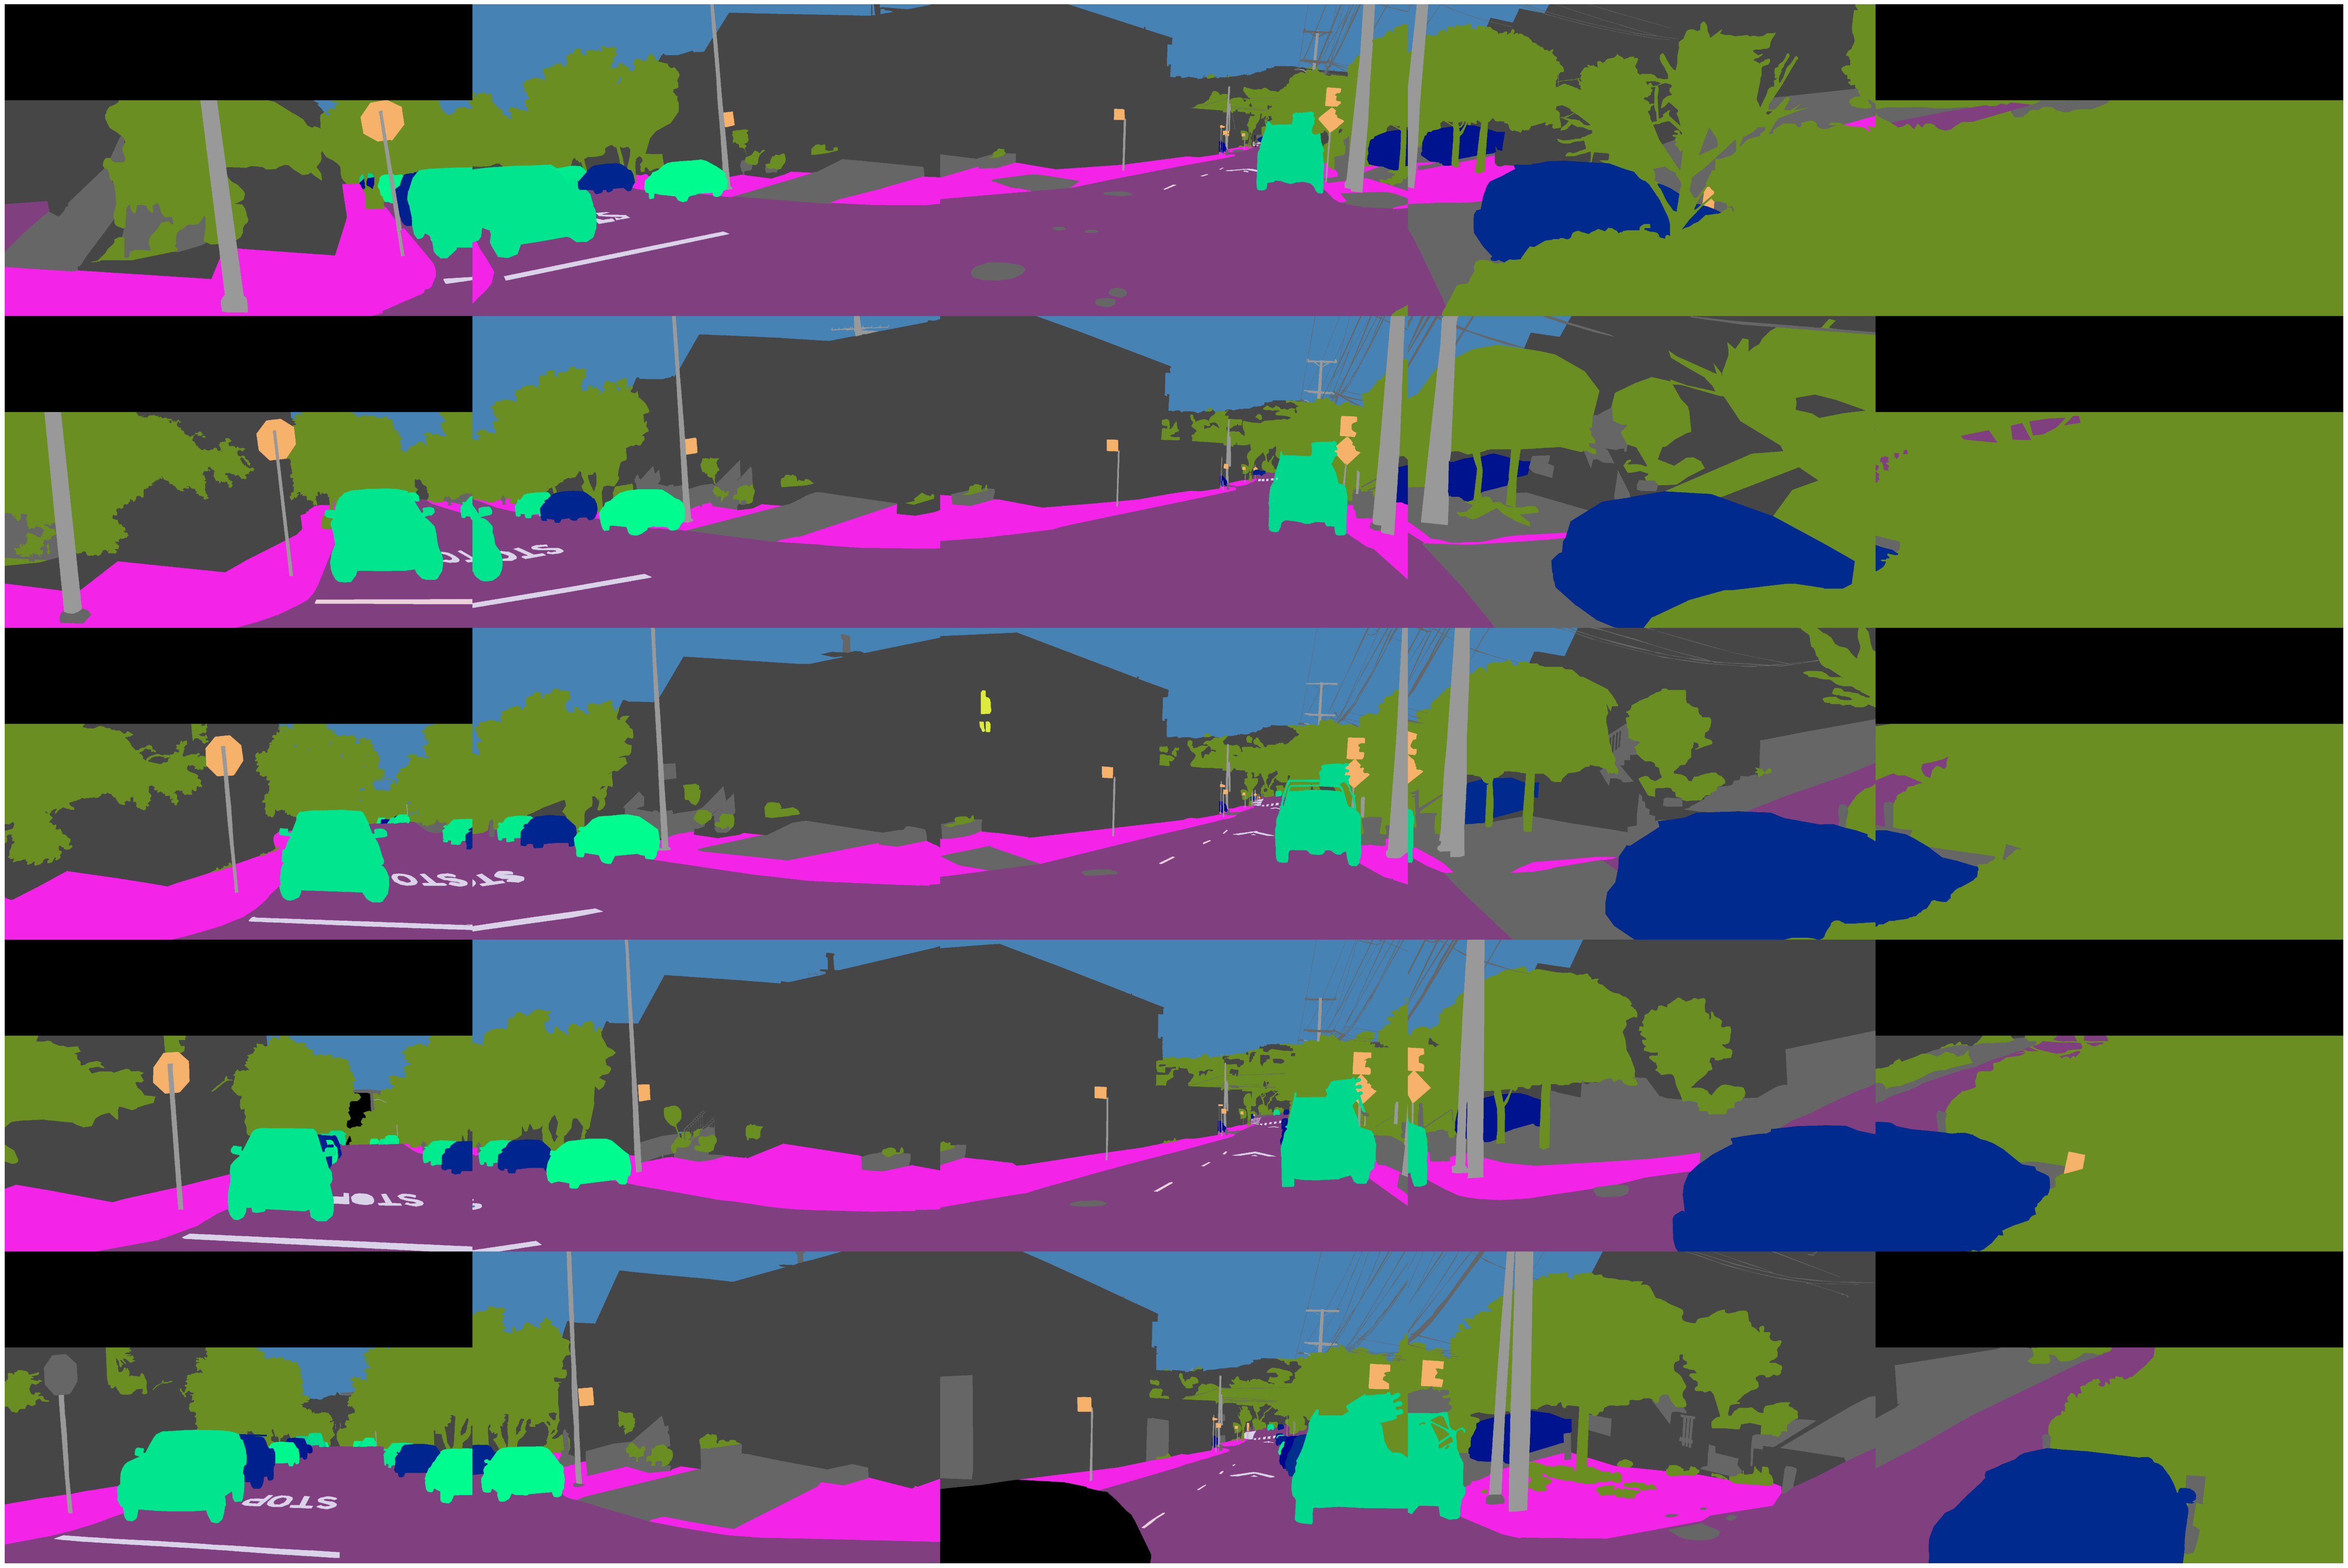

In [107]:
# SO its taken the frames at 0 , 5 and 10 and shown the panoptic seg og each of the fowllowing.
plt.figure(figsize=(64, 60))
plt.imshow(panoptic_label_rgb)
plt.grid(False)
plt.axis('off')
plt.show()